In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/d2nn

/content/drive/My Drive/d2nn


In [ ]:
import tensorflow as tf
import numpy as np
from math import pi
from tensorflow.keras import layers
from scipy.fftpack import fft2
import time
import os
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import pprint
from tempfile import TemporaryFile

In [ ]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13325839485010478561, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10170603967253196905
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10265564024912267728
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17817310214406210475
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

Image Domain Functions

In [ ]:
class grating_layer(layers.Layer):
    ''' Generates grating multiplication layer
        Spatially multiplies input with grating layer
    '''
    def __init__(self, period, grating_type):
        super(grating_layer, self).__init__()
        self.period = period
        self.grating_type = grating_type

    def call(self, x, y):
        if self.grating_type == 'sin_phase':
            self.grating = self.generate_sinudoidal_phase_grating(x.get_shape()[1])
        elif self.grating_type == 'bin_phase':
            self.grating = self.generate_binary_phase_grating(x.get_shape()[1])
        elif self.grating_type == 'bin':
            self.grating = self.generate_binary_grating(x.get_shape()[1])
        return [tf.map_fn(self.apply_grating, x), tf.map_fn(self.apply_grating, y)]

    def apply_grating(self, x):
        return tf.math.multiply(x, self.grating)

    def generate_binary_grating(self, image_dimension):
        number_of_gratings = tf.constant([image_dimension//self.period], 'int64')
        x = tf.linspace(0.0, 1, self.period)
        unit_grating = tf.math.sin(x, 'complex64')
        grating_1d = tf.tile(unit_grating, number_of_gratings, 'complex64')
        [grating_2dx, grating_2dy] = tf.meshgrid(grating_1d, grating_1d)
        grating_2d = tf.math.multiply(grating_2dx, grating_2dy)
        return tf.cast(tf.math.exp(grating_2d), 'complex64')

    def generate_sinudoidal_phase_grating(self, image_dimension):
        number_of_gratings = tf.constant([image_dimension//self.period], 'int64')
        x = tf.linspace(0.0, 2*pi, self.period)
        unit_grating = tf.math.sin(x, 'complex64')
        grating_1d = tf.tile(unit_grating, number_of_gratings, 'complex64')
        [grating_2dx, grating_2dy] = tf.meshgrid(grating_1d, grating_1d)
        grating_2d = tf.math.multiply(grating_2dx, grating_2dy)
        return tf.cast(tf.math.exp(grating_2d), 'complex64')

    def generate_binary_phase_grating(self, image_dimension):
        number_of_gratings = tf.constant([image_dimension//self.period], 'int64')
        #unit_grating = tf.constant(np.array([0.0] + [1.0]*(self.period - 2) + [0.0]), 'complex64')
        grating_1d = tf.cast(tf.constant(np.array([0, pi]*int((28*self.period)//2))), 'complex64')
        [grating_2dx, grating_2dy] = tf.meshgrid(grating_1d, grating_1d)
        grating_2d = tf.math.multiply(grating_2dx, grating_2dy)
        return tf.cast(tf.math.exp(grating_2d), 'complex64')

class batch_normalize_2_images(layers.Layer):

    def __init__(self):
        super(batch_normalize_2_images, self).__init__()

    def call(self, x, y):
        epsilon = 1e-3
        stack = tf.math.divide(tf.math.add(x, y), tf.constant(2.0, 'complex64'))
        batch_mean2, batch_var2 = tf.nn.moments(x=stack,axes=[0])
        batch_mean2 = tf.cast(batch_mean2, 'float32')
        batch_var2 = tf.cast(batch_var2, 'float32')
        scale2 = tf.cast(tf.Variable(tf.ones(stack.get_shape())), 'float32')
        beta2 = tf.cast(tf.Variable(tf.zeros(stack.get_shape())), 'float32')
        BN_x = tf.nn.batch_normalization(x, batch_mean2, batch_var2, beta2, scale2, epsilon)
        BN_y = tf.nn.batch_normalization(y, batch_mean2, batch_var2, beta2, scale2, epsilon)
        return BN_x, BN_y

class normalize_2_complex_images(layers.Layer):

    def __init__(self):
        super(normalize_2_complex_images, self).__init__()

    def call(self, x, y):
        [norm_x, norm_y] = tf.map_fn(self.apply_conv, [x, y])
        return [norm_x, norm_y]

    def apply_conv(self, xy):
        [x, y] = xy
        x_max = tf.reduce_max(input_tensor=tf.abs(x))
        y_max = tf.reduce_max(input_tensor=tf.abs(y))
        max_val = tf.cond(pred=tf.math.greater(x_max, y_max), true_fn=lambda: x_max, false_fn=lambda: y_max)
        norm_x = tf.math.divide(x, tf.cast(max_val, 'complex64'))
        norm_y = tf.math.divide(y, tf.cast(max_val, 'complex64'))
        return [norm_x, norm_y]

class scale_2_complex_images(layers.Layer):
    ''' Resizes images to original shape x scale
            Original shape x scale must be integer number
            Tensorflow does not support resizing complex valued tensors
            tf.image.resize 
    '''
    def __init__(self, scale):
        super(scale_2_complex_images, self).__init__()
        self.scale = scale

    def call(self, x, y):
        sx = tf.map_fn(self.apply_scale, x)
        sy = tf.map_fn(self.apply_scale, y)
        return [sx, sy]

    def apply_scale(self, x):
        ''' Takes 2-D Tensor, returns scaled 2-D Tensor '''
        s = tf.identity(x)
        s_shape = tf.shape(input=s)
        s = tf.reshape(s, [s_shape[0], s_shape[1], 1])
        s = tf.tile(s, [1, 1, self.scale])
        s = tf.reshape(s, [s_shape[0], s_shape[1]*self.scale])
        s = tf.reshape(s, [s_shape[0], s_shape[1]*self.scale, 1])
        s = tf.tile(s, [1, 1, self.scale])
        s = tf.transpose(a=s, perm=[0, 2, 1])
        s = tf.reshape(s, [s_shape[0]*self.scale, s_shape[1]*self.scale])
        return s

Optical Layers

In [ ]:
class propagation_layer(layers.Layer):
    ''' Propagator layer with fft convolution implementation
        fft empirically determined to be faster for large kernels
        Input to fsp layer must be physical values
    '''
    def __init__(self, source_grid_size, lc_array_size, dx, dist, wavelength, prop_type):
        super(propagation_layer, self).__init__()
        self.source_grid_size = source_grid_size
        self.lc_array_size = lc_array_size
        self.dx = dx
        self.prop_dist = dist
        self.wavelength = wavelength
        if prop_type == 'TF':
            self.propagator = self.make_TF_propagator()
        elif prop_type == 'RS':
            self.propagator = self.make_RS_propagator()

    def make_TF_propagator(self):
        L = self.lc_array_size
        dx = self.dx
        prop_dist = self.prop_dist
        wavelength = self.wavelength
        fx = np.arange(-1/(2*dx), 1/(2.*dx), 1/L)
        [FX, FY] = np.meshgrid(fx, fx)
        H = np.exp(-1j*pi*wavelength*prop_dist*(np.square(FX) + np.square(FY)))
        H = np.fft.fftshift(H)
        return tf.constant(H, 'complex64')

    def make_RS_propagator(self):
        lc_array_size = self.lc_array_size
        k = 1.0/self.wavelength
        x = np.linspace(-lc_array_size/2.0, lc_array_size/2.0, int(self.source_grid_size))
        #dx = tf.constant(lc_array_size/self.source_grid_size, 'complex64')
        dx = tf.constant(1.0, 'complex64')
        [rhox, rhoy] = np.meshgrid(x, x)
        rho2 = np.sqrt(rhox**2 + rhoy**2)
        #z = tf.cast(tf.identity(self.prop_dist), 'complex64') 
        z_var = tf.identity(self.prop_dist)
        z = tf.cast(z_var, 'complex64')
        imag_j = tf.constant(-1j, 'complex64')
        k = tf.constant(k, 'complex64')
        rho2 = tf.constant(rho2, 'complex64')
        one = tf.constant(1.0, 'complex64')
        two = tf.constant(2.0, 'complex64')
        pi_const = tf.constant(pi, 'complex64')
        a = tf.math.divide(-imag_j*k*z, (rho2+tf.math.square(z)))
        b = tf.math.exp(imag_j*two*pi_const*k*tf.math.sqrt(rho2 + tf.math.square(z)))
        c = (one + tf.math.divide(imag_j, two*pi_const*k*tf.math.sqrt(rho2+tf.math.square(z))))

        # h = tf.constant(-1j*k*z/(rho2+z**2)*np.exp(1j*2*pi*k*np.sqrt(rho2 + z**2))*(1+ 1j/2/pi/k/np.sqrt(rho2+z**2)), 'complex64')
        h = a*b*c
        H = tf.math.multiply(tf.signal.fft2d(tf.signal.fftshift(h)), tf.math.square(dx))
        return H

    def call(self, x, y):
        x = tf.cast(x, 'complex64')
        y = tf.cast(y, 'complex64')
        [conv_x, conv_y] = tf.map_fn(self.apply_conv, [x, y])
        return [conv_x, conv_y]

    def apply_conv(self, xy):
    	[x, y] = xy
    	conv_x = self.conv2dfft(self.propagator, x)
    	conv_y = self.conv2dfft(self.propagator, y)
    	return [conv_x, conv_y]

    def conv2dfft(self, A, B):
    	B = tf.signal.fft2d(tf.signal.fftshift(B))
    	fftAB = tf.math.multiply(A, B)
    	return tf.signal.ifftshift(tf.signal.ifft2d(fftAB))

class lc_layer(layers.Layer):
    ''' Implements Liquid Crystal layer based on paper
    	reference: 
        Make 28x28 Weights
        Scale weight matrix to image size
        Update weights
    '''
    def __init__(self, num_weights, scale, wavelength, layer_type):
        super(lc_layer, self).__init__()
        num_weights = int(num_weights)
        self.scale = scale
        self.layer_type = layer_type
        self.wavelength = wavelength
        if layer_type == 'rotator':
            self.theta = tf.Variable(initial_value = np.random.normal(0.0, 1.0, (num_weights, num_weights)), trainable = True)
        elif layer_type == 'lc':
            self.ne_theta = tf.Variable(initial_value = np.random.normal(0.0, 1.0, (num_weights, num_weights)), trainable = True)
            Ae, Be, Ce = 1.6708, 0.0081, 0.0024
            Ao, Bo, Co = 1.5139, 0.0052, 0.0008
            wavelength_um= wavelength/1e-6
            self.ne = Ae + Be/wavelength_um**2 + Ce/wavelength_um**4
            self.no = Ao + Bo/wavelength_um**2 + Co/wavelength_um**4
            self.d = 1e-4

    def call(self, x, y):
        self.batch_size = x.get_shape()[0]
        if self.layer_type == 'rotator':
            scaled_theta = self.scale_weights() 
            return self.rotator(x, y, scaled_theta)
        elif self.layer_type == 'lc':
            scaled_ne_theta = self.scale_weights() 
            return self.lc(x, y, scaled_ne_theta)

    def scale_weights(self):
        ''' Scales weights from nxn to n*scale x n*scale
            For example, scales 28x28 to 2800x2800 if scale = 100, each 1 pixel
                is scaled to 100x100
        '''
        multiplier = int(1/self.scale)
        if self.layer_type == 'lc':
            w = tf.identity(self.ne_theta)
        elif self.layer_type == 'rotator':
            w = tf.identity(self.theta)
        w_shape = tf.shape(input=w)
        w = tf.reshape(w, [w_shape[0], w_shape[1], 1])
        w = tf.tile(w, [1, 1, multiplier])
        w = tf.reshape(w, [w_shape[0], w_shape[1]*multiplier])
        w = tf.reshape(w, [w_shape[0], w_shape[1]*multiplier, 1])
        w = tf.tile(w, [1, 1, multiplier])
        w = tf.transpose(a=w, perm=[0, 2, 1])
        w = tf.reshape(w, [1, w_shape[0]*multiplier, w_shape[1]*multiplier])
        w = tf.tile(w, [self.batch_size, 1, 1])
        return w

    def lc(self, x, y, ne_theta):
        d = self.d
        ne_theta = tf.cast(ne_theta, 'complex64')
        wavelength = self.wavelength
        pidlambda_term = pi*d/wavelength
        beta = pidlambda_term*(ne_theta - self.no)
        phi = pidlambda_term*(ne_theta + self.no)
        gamma = tf.math.sqrt(np.square(pi/2.0) + tf.math.square(beta))

        a = pi/2.0/gamma*tf.math.sin(gamma)
        b = tf.math.cos(gamma) + 1j*beta/gamma*tf.math.sin(gamma)
        c = -tf.math.cos(gamma) + 1j*beta/gamma*tf.math.sin(gamma)
        d = pi/2.0/gamma*tf.math.sin(gamma)

        return [tf.math.exp(-1j*phi)*(a*x + b*y), tf.math.exp(-1j*phi)*(c*x + d*y)]

    def rotator(self, x, y, theta):
        outputx = tf.math.multiply(x, tf.cast(tf.math.cos(theta), 'complex64')) - tf.math.multiply(y, tf.cast(tf.math.sin(theta), 'complex64'))
        outputy = tf.math.multiply(x, tf.cast(tf.math.sin(theta), 'complex64')) + tf.math.multiply(y, tf.cast(tf.math.cos(theta), 'complex64'))
        return [outputx, outputy]

class eval_layer(layers.Layer):
    ''' Converts output to one hot form
        Applies softmax

        slice matrix/unpad
        pool
    '''
    def __init__(self):
        super(eval_layer, self).__init__()

    def call(self, x):
        Ix = tf.cast(tf.math.square(tf.math.abs(x)), 'float32')
        r = tf.map_fn(self.eval, Ix)
        r = tf.cast(r, 'float32')
        return r

    def eval(self, Ix):
        # im = self.unpad(Ix)
        im = Ix
        ws = im.shape[0]//4
        pooled =  tf.nn.pool(input=tf.cast(tf.reshape(im,
                            [1, im.shape[0], im.shape[1], 1]),'float32'),
                            window_shape = (ws, ws), pooling_type = 'AVG',
                            padding = 'SAME', strides = [ws, ws])
        pooled = tf.reshape(tf.reshape(pooled, [4, 4]), [1, 16])[0][0:10]
        pooled = tf.cast(pooled, 'float32')
        r = tf.cast(tf.nn.softmax(pooled), 'float32')
        return r

Build Model

In [ ]:
class d2nn_model(object):
    def __init__(self):
        #super(YourModel, self).__init__()
        self.num_epoch = 1
        self.batch_size = 64
        self.log_step = 100
        self.lr = 5e-2
        self._build_model()

    def m(self):

        input_shape = 28
        wavelength = 690e-9
        lc_size = 2e-6
        prop_dist = 2.5e-2

        im_rescale = 10
        pixels_per_lc = 1

        scale1 = scale_2_complex_images(im_rescale*pixels_per_lc)
        #grating = grating_layer(im_rescale*pixels_per_lc, 'sin_phase')
        #grating = grating_layer(2, 'bin')
        grating = lambda a, b: (a, b)
        num_weights = input_shape*im_rescale
        lc1 = lc_layer(num_weights, 1.0/pixels_per_lc, wavelength, 'rotator')
        normalize = normalize_2_complex_images()
        #normalize = lambda a, b: (a, b)

        source_grid_size = input_shape*im_rescale*pixels_per_lc
        lc_array_size = input_shape*im_rescale*lc_size
        dx = lc_size/pixels_per_lc
        propagate1 = propagation_layer(source_grid_size, lc_array_size, dx, prop_dist, wavelength, 'TF')
        evaluate = eval_layer()

        with tf.compat.v1.variable_scope('scale1'):
            self.x0, self.y0 = scale1(self.pol_x, self.pol_y)
        with tf.compat.v1.variable_scope('b1'):
            self.xl1, self.yl1 = lc1(self.x0, self.y0)
            self.xg1, self.yg1 = grating(self.xl1, self.yl1)
            self.xp1, self.yp1 = propagate1(self.xg1, self.yg1)
            #self.xn1, self.yn1 = normalize(self.xp1, self.yp1)
        with tf.compat.v1.variable_scope('b2'):
            self.xl2, self.yl2 = lc1(self.xp1, self.yp1)
            self.xg2, self.yg2 = grating(self.xl2, self.yl2)
            self.xp2, self.yp2 = propagate1(self.xg2, self.yg2)
            #self.xn2, self.yn2 = normalize(self.xp2, self.yp2)
        with tf.compat.v1.variable_scope('b3'):
            self.xl3, self.yl3 = lc1(self.xp2, self.yp2)
            self.xg3, self.yg3 = grating(self.xl3, self.yl3)
            self.xp3, self.yp3 = propagate1(self.xg3, self.yg3)
            self.xn3, self.yn3 = normalize(self.xp3, self.yp3)
        # with tf.compat.v1.variable_scope('b4'):
        #     self.xl4, self.yl4 = lc1(self.xp3, self.yp3)
        #     self.xg4, self.yg4 = grating(self.xl4, self.yl4)
        #     self.xp4, self.yp4 = propagate1(self.xg4, self.yg4)
        #     #self.xn4, self.yn4 = normalize(self.xp4, self.yp4)
        # with tf.compat.v1.variable_scope('b5'):
        #     self.xl5, self.yl5 = lc1(self.xp4, self.yp4)
        #     self.xg5, self.yg5 = grating(self.xl5, self.yl5)
        #     self.xp5, self.yp5 = propagate1(self.xg5, self.yg5)
        #     self.xn5, self.yn5 = normalize(self.xp5, self.yp5)
        # with tf.compat.v1.variable_scope('b6'):
        #     self.xl6, self.yl6 = lc1(self.xn5, self.yn5)
        #     self.xg6, self.yg6 = grating(self.xl6, self.yl6)
        #     self.xp6, self.yp6 = propagate1(self.xg6, self.yg6)
        #     self.xn6, self.yn6 = normalize(self.xp6, self.yp6)
        # with tf.compat.v1.variable_scope('b7'):
        #     self.xl7, self.yl7 = lc1(self.xn6, self.yn6)
        #     self.xg7, self.yg7 = grating(self.xl7, self.yl7)
        #     self.xp7, self.yp7 = propagate1(self.xg7, self.yg7)
        #     self.xn7, self.yn7 = normalize(self.xp7, self.yp7)
        # with tf.compat.v1.variable_scope('b8'):
        #     self.xl8, self.yl8 = lc1(self.xn7, self.yn7)
        #     self.xg8, self.yg8 = grating(self.xl8, self.yl8)
        #     self.xp8, self.yp8 = propagate1(self.xg8, self.yg8)
        #     self.xn8, self.yn8 = normalize(self.xp8, self.yp8)
        # with tf.compat.v1.variable_scope('b9'):
        #     self.xl9, self.yl9 = lc1(self.xn8, self.yn8)
        #     self.xg9, self.yg9 = grating(self.xl9, self.yl9)
        #     self.xp9, self.yp9 = propagate1(self.xg9, self.yg9)
        #     self.xn9, self.yn9 = normalize(self.xp9, self.yp9)
        # with tf.compat.v1.variable_scope('b10'):
        #     self.xl10, self.yl10 = lc1(self.xn9, self.yn9)
        #     self.xg10, self.yg10 = grating(self.xl10, self.yl10)
        #     self.xp10, self.yp10 = propagate1(self.xg10, self.yg10)
        #     self.xn10, self.yn10 = normalize(self.xp10, self.yp10)
        # with tf.compat.v1.variable_scope('b11'):
        #     self.xl11, self.yl11 = lc1(self.xn10, self.yn10)
        #     self.xg11, self.yg11 = grating(self.xl11, self.yl11)
        #     self.xp11, self.yp11 = propagate1(self.xg11, self.yg11)
        #     self.xn11, self.yn11 = normalize(self.xp11, self.yp11)
        # with tf.compat.v1.variable_scope('b12'):
        #     self.xl12, self.yl12 = lc1(self.xn11, self.yn11)
        #     self.xg12, self.yg12 = grating(self.xl12, self.yl12)
        #     self.xp12, self.yp12 = propagate1(self.xg12, self.yg12)
        #     self.xn12, self.yn12 = normalize(self.xp12, self.yp12)
        with tf.compat.v1.variable_scope('eval1'):
            self.result = evaluate(self.xn3)
        return self.result

    def _input_ops(self):
        # Placeholders
        self.pol_x = tf.compat.v1.placeholder(tf.complex64, [self.batch_size, None, None])
        self.pol_y = tf.compat.v1.placeholder(tf.complex64, [self.batch_size, None, None])
        self.Y = tf.compat.v1.placeholder(tf.int64, [self.batch_size])
        self.is_train = tf.compat.v1.placeholder(tf.bool)
        self.keep_prob = tf.compat.v1.placeholder(tf.float32)

    def _build_optimizer(self):
        self.train_op = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(self.loss_op)
        #self.train_op = tf.compat.v1.train.RMSPropOptimizer(self.lr).minimize(self.loss_op)

    def _loss(self, labels, logits):
        self.loss_op = tf.reduce_mean(input_tensor=tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(tf.one_hot(self.Y,10)), logits=self.result))

    def _build_model(self):
        # Define input variables
        self._input_ops()
        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)
        # Build a model and get logits
        logits = self.m()
        # Compute loss
        self._loss(labels, logits)
        # Build optimizer
        self._build_optimizer()
        # Compute accuracy
        predict = tf.argmax(input=logits, axis=1)
        correct = tf.equal(predict, self.Y)
        self.confusion_matrix = tf.math.confusion_matrix(labels=self.Y, predictions=predict, num_classes=10)
        self.accuracy_op = tf.reduce_mean(input_tensor=tf.cast(correct, tf.float32))

    def train(self, sess, XX_train, XY_train, Y_train, XX_val, XY_val, Y_val):
        sess.run(tf.compat.v1.global_variables_initializer())
        step = 0
        losses = []
        accuracies = []
        validations = []
        dval = []
        confusion_matrices = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        start=datetime.now()
        for epoch in range(self.num_epoch):
            XX_train, Y_train = shuffle(XX_train, Y_train)
            print('train for epoch %d' % epoch)
            for i in range(XX_train.shape[0] // self.batch_size):
                XX_ = XX_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                XY_ = XY_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]
                feed_dict = {self.pol_x: XX_,
                             self.pol_y: XY_,
                             self.Y: Y_,
                             self.is_train: True}
                fetches = [self.train_op, self.loss_op, self.accuracy_op, self.confusion_matrix]

                _, loss, accuracy, confusion = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)
                confusion_matrices.append(confusion)

                runtime = datetime.now()-start

                np.save('rot_acc_data_iteration.npy', accuracies)
                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f, time = ' % (step, loss, accuracy) + str(runtime))
                step += 1
                if step % 3000 == 0:
                    self.lr = self.lr*0.9

            savestring = 'tr_s20_d2en3_ws1_bs8_lr5en3adam_32bit_8layers_bingrating2_690nm_8k'
    
            # Plot training curves
            plt.subplot(3, 1, 1)
            plt.plot(losses)
            plt.ylabel('Loss')
            plt.xlabel('Iteration')
            plt.grid(True)
            ## Graph 2. X: epoch, Y: training accuracy
            #plt.subplot(3, 1, 2)
            #plt.plot(accuracies)
            #plt.grid(True)
            #plt.xlabel('Iteration (Epoch {}'.format(epoch+1) + ')')
            #plt.ylabel('Training Accuracy') 

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy, confusion_matrix = self.evaluate(sess, XX_val, XY_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
            validations.append(val_accuracy)
            epoches = np.arange(epoch + 1)
            if epoch > 3:      
                dval.append(np.average(np.gradient(validations[-4:])))
                plt.subplot(3, 1, 2)
                plt.plot(epoches[4:], dval)
                plt.xlabel('Epoch')
                plt.ylabel('dval/dEpoch')
                plt.grid(True)
                for x, y in zip(epoches[4:], dval):
                    plt.text(x, y, str(float(y)), color = 'red', fontsize = 3, rotation = 90)

            plt.subplot(3, 1, 3)
            plt.plot(epoches, validations)
            plt.xlabel('Epoch')
            plt.ylabel('Val acc')
            plt.grid(True)
            for x, y in zip(epoches, validations):
                plt.text(x, y, str(float(y)), color = 'red', fontsize = 3, rotation = 90)
            plt.savefig(savestring + '.png', dpi = 1000)
            np.save('rot_val_data.npy', np.vstack((epoches, validations)))
            np.save('rot_loss_data.npy', losses)
            np.save('amp_confusion.npy', confusion_matrices)


    def evaluate(self, sess, XX_eval, XY_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        confusion_matrix = np.zeros((10, 10))
        for i in range(XX_eval.shape[0] // self.batch_size):
            XX_ = XX_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            XY_ = XY_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]

            feed_dict = {self.pol_x: XX_,
                         self.pol_y: XY_,
                            self.Y: Y_,
                            self.is_train: False}

            accuracy, confusion = sess.run([self.accuracy_op, self.confusion_matrix], feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
            confusion_matrix += confusion
        return eval_accuracy / eval_iter, confusion_matrix

Run Model

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

Loading Pickled Data...
-----  Start training  -----
train for epoch 0
iteration (0): loss = 2.303, accuracy = 0.078, time = 0:00:01.923968
iteration (100): loss = 2.299, accuracy = 0.719, time = 0:01:29.464098
iteration (200): loss = 2.298, accuracy = 0.719, time = 0:02:55.340552
iteration (300): loss = 2.298, accuracy = 0.703, time = 0:04:20.568360
iteration (400): loss = 2.298, accuracy = 0.688, time = 0:05:46.953949
iteration (500): loss = 2.298, accuracy = 0.766, time = 0:07:13.753766
iteration (600): loss = 2.298, accuracy = 0.672, time = 0:08:40.289529
iteration (700): loss = 2.297, accuracy = 0.766, time = 0:10:06.891128
validation for epoch 0
-  epoch 0: validation accuracy = 0.

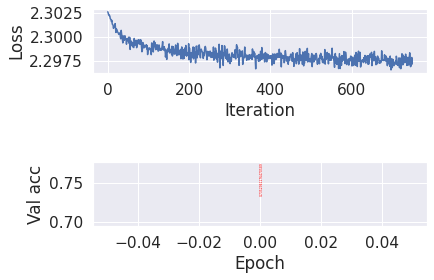

In [ ]:
def shuffle(X, Y):
    train_indices = np.arange(X.shape[0])
    np.random.shuffle(train_indices)
    X_result = X[train_indices,:, :]
    Y_result = Y[train_indices]
    return X_result, Y_result

def load_mnist_data():
    with open('mnist.pickle', 'rb') as f:
        print('Loading Pickled Data...')
        return pickle.load(f)

if __name__ == '__main__':
    # Clear old computational graphs
    tf.compat.v1.reset_default_graph()
    config = tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=True)
    with tf.compat.v1.Session(config=config) as sess:

        (x_train, y_train), (x_test, y_test) = load_mnist_data()
        # features = features.astype('float32')
        # labels = labels.astype('float32')
        # x_train, y_train = shuffle(features, labels)
        # xx_train = features[::5000, :, :, 0]
        # xy_train = xx_train.copy()
        # y_train = labels[::5000]
        # xx_val = features[5000:6000, :, :, 0]
        # xy_val = xx_val.copy()
        # y_val = labels[5000:6000]
        # xx_test = features[6000:7000, :, :, 0]
        # xy_test = xx_test.copy() 
        # y_test = labels[6000:7000]     

        # train all
        # x_val = x_train[-10000:, :, :].astype('float64')
        # y_val = y_train[-10000:].astype('float64')
        # xx_train = x_train[:-10000, :, :].astype('float64')
        # xy_train = np.zeros(xx_train.shape).astype('float64') + 1e-15
        # y_train = y_train[:-10000].astype('float64')
        # x_test = x_test.astype('float64')
        # y_test = y_test.astype('float64')

        x_train, y_train = shuffle(x_train, y_train)
        x_test, y_test = shuffle(x_test, y_test)

        num_train = 48000
        num_val = 12000
        num_test = 10000
        xx_val = x_train[-num_val:, :, :].astype('float32')
        xy_val = np.zeros(xx_val.shape).astype('float32') + 1e-50
        y_val = y_train[-num_val:].astype('float32')
        xx_train = x_train[:num_train, :, :].astype('float32')
        xy_train = np.zeros(xx_train.shape).astype('float32') + 1e-50
        y_train = y_train[:num_train].astype('float32')
        xx_test = x_test[:num_test].astype('float32')
        xy_test = np.zeros(xx_test.shape).astype('float32') + 1e-50
        y_test = y_test[:num_test].astype('float32')

        model = d2nn_model()

        sess.run(tf.compat.v1.global_variables_initializer())
        #variables_names = [v.name for v in tf.trainable_variables()]
        #values = sess.run(variables_names)
        #for k, v in zip(variables_names, values):
        #    print( "Variable: ", k)
        #    print("Shape: ", v.shape)
        #    print(v)

        model.train(sess, xx_train, xy_train, y_train, xx_val, xy_val, y_val)
        accuracy, confusion_matrix = model.evaluate(sess, xx_test, xy_test, y_test)
        print(confusion_matrix)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.compat.v1.train.Saver()
        model_path = saver.save(sess, "d2nn_model_rotator.ckpt")
        print("Model saved in %s" % model_path)

In [ ]:
with np.printoptions(precision=3, suppress=True):
    print(confusion_matrix/np.sum(confusion_matrix, axis = 0))

[[0.656 0.001 0.003 0.003 0.    0.    0.017 0.001 0.007 0.   ]
 [0.    0.646 0.001 0.001 0.    0.    0.004 0.    0.012 0.   ]
 [0.05  0.091 0.921 0.019 0.02  0.    0.033 0.024 0.05  0.001]
 [0.02  0.021 0.024 0.649 0.    0.    0.009 0.021 0.032 0.007]
 [0.008 0.028 0.003 0.002 0.908 0.    0.039 0.004 0.013 0.159]
 [0.156 0.062 0.001 0.216 0.021 1.    0.047 0.041 0.126 0.047]
 [0.045 0.018 0.014 0.001 0.004 0.    0.821 0.    0.002 0.   ]
 [0.009 0.042 0.017 0.001 0.007 0.    0.002 0.817 0.009 0.027]
 [0.029 0.067 0.004 0.097 0.001 0.    0.023 0.026 0.739 0.021]
 [0.026 0.023 0.011 0.013 0.039 0.    0.005 0.067 0.01  0.739]]


In [ ]:
confusion_matrix

array([[9.450e+02, 1.000e+00, 2.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        1.800e+01, 1.000e+00, 6.000e+00, 0.000e+00],
       [0.000e+00, 1.117e+03, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        4.000e+00, 0.000e+00, 1.000e+01, 0.000e+00],
       [7.200e+01, 1.580e+02, 6.570e+02, 2.500e+01, 1.500e+01, 0.000e+00,
        3.400e+01, 2.600e+01, 4.100e+01, 1.000e+00],
       [2.900e+01, 3.700e+01, 1.700e+01, 8.590e+02, 0.000e+00, 0.000e+00,
        9.000e+00, 2.300e+01, 2.600e+01, 8.000e+00],
       [1.200e+01, 4.900e+01, 2.000e+00, 2.000e+00, 6.920e+02, 0.000e+00,
        4.000e+01, 4.000e+00, 1.100e+01, 1.700e+02],
       [2.250e+02, 1.070e+02, 1.000e+00, 2.860e+02, 1.600e+01, 1.000e+01,
        4.800e+01, 4.400e+01, 1.040e+02, 5.000e+01],
       [6.500e+01, 3.200e+01, 1.000e+01, 1.000e+00, 3.000e+00, 0.000e+00,
        8.450e+02, 0.000e+00, 2.000e+00, 0.000e+00],
       [1.300e+01, 7.300e+01, 1.200e+01, 1.000e+00, 5.000e+00, 0.000e+00,
        2.000e+00, 8.840e+02, 7.000e+

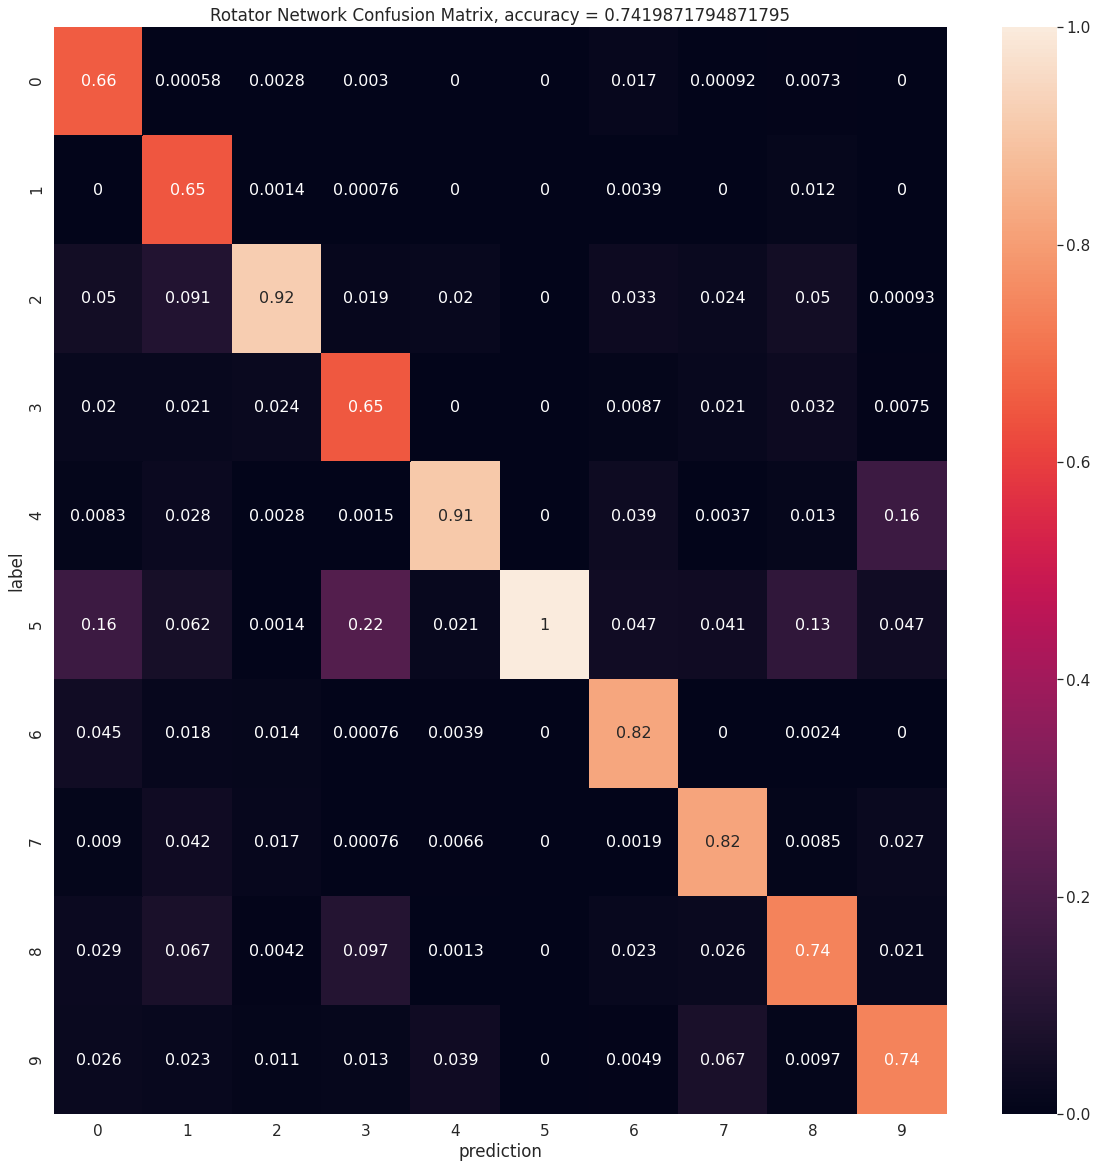

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(pd.DataFrame(confusion_matrix/np.sum(confusion_matrix, axis = 0), range(10), range(10)), annot=True, annot_kws={"size": 16}) # font size
ax.set(xlabel='prediction', ylabel='label', title = 'Rotator Network Confusion Matrix, accuracy = ' + str(accuracy))
plt.show()


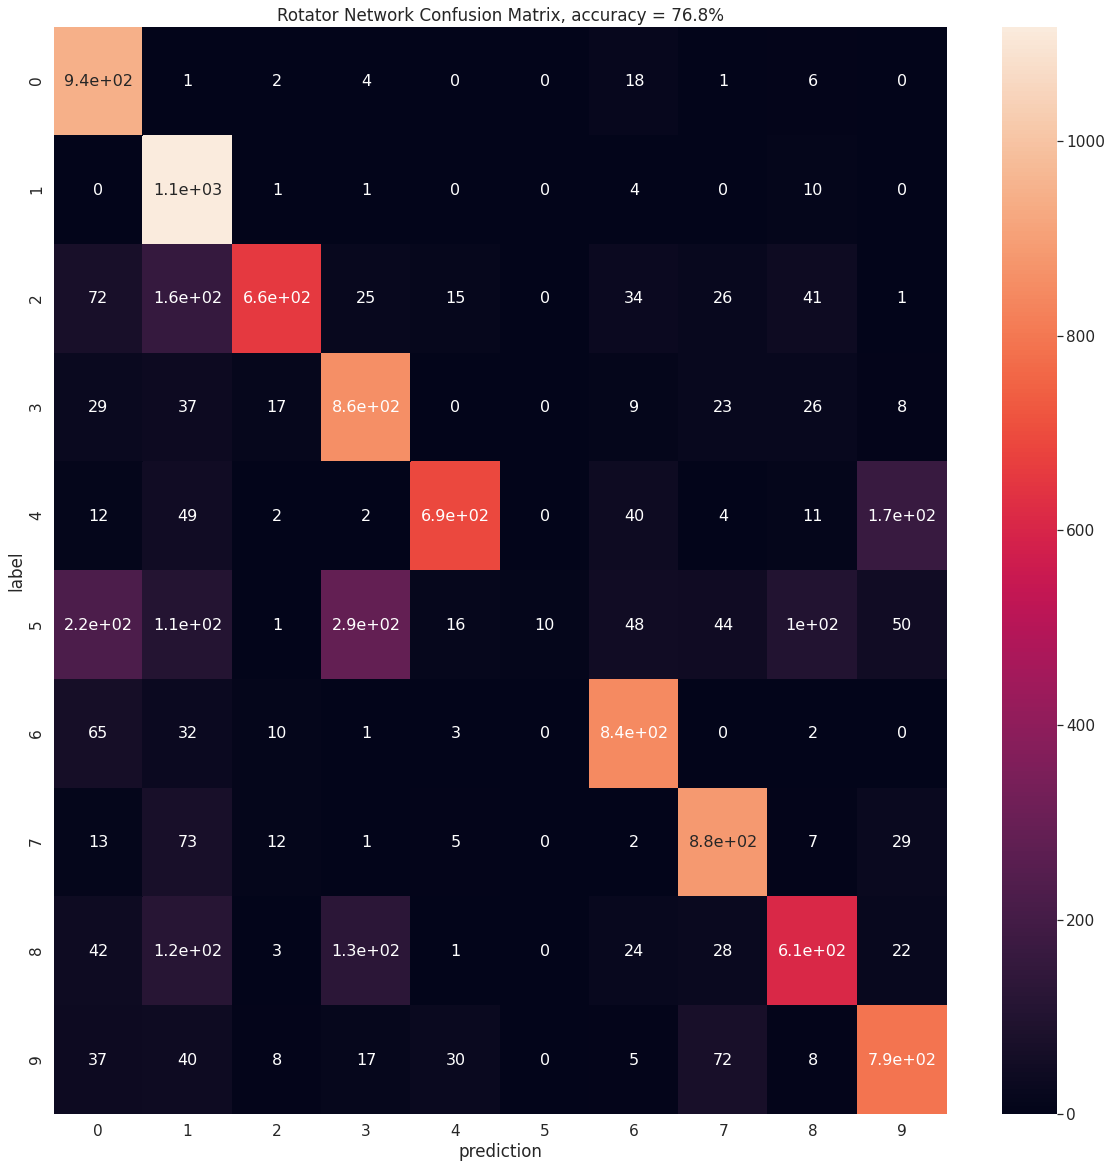

In [ ]:
plt.figure(figsize=(20,20))
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(pd.DataFrame(confusion_matrix, range(10), range(10)), annot=True, annot_kws={"size": 16}) # font size
ax.set(xlabel='prediction', ylabel='label', title = 'Rotator Network Confusion Matrix, accuracy = 76.8%')
plt.show()
